1. Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной". Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин. Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

2. Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

 - ARPU
 - ARPAU
 - CR в покупку
 - СR активного пользователя в покупку
 - CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы. Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах. Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [2]:
# Импортируем библиотеки и задаем настройки отображения
import pandas as pd
import pandahouse as ph

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy.stats as stats
from scipy.stats import norm

sns.set(
    style="whitegrid",
    rc={'figure.figsize': (20, 7)})
pd.set_option('display.precision', 2)

In [3]:
# зададим параметры подключения к ClickHouse
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'
                     }

In [4]:
# создаем запрос по задаче 1
q = '''
    SELECT COUNT(st_id) AS diligent_student
    FROM (
        SELECT st_id
        FROM {db}.peas
        WHERE toMonth(timest) = (SELECT MAX(toMonth(timest)) FROM {db}.peas)
        GROUP BY st_id
        HAVING SUM(correct) >= 20)
    
    '''
# отправляем запрос и записываем результат в датафрейм
diligent = ph.read_clickhouse(query=q, connection=connection_default)
print(f' Количество усердных студентов, решивших более 20 заданий за текущий месяц {diligent.diligent_student.min()}')

 Количество усердных студентов, решивших более 20 заданий за текущий месяц 136


In [5]:
# создаем запрос по задаче 2
q = '''
    SELECT test_grp AS group,
        COUNT(DISTINCT studs.st_id) AS users,
        COUNT(DISTINCT CASE WHEN money>0 THEN a2.st_id END) AS payed_users,
        COUNT(DISTINCT CASE WHEN money>0 AND sum_correct>10 THEN a1.st_id END) AS payed_active_users,
        COUNT(DISTINCT CASE WHEN sum_correct>10 THEN a1.st_id END)  AS users_active,
        COUNT(DISTINCT CASE WHEN money>0 AND sum_correct_math>=2 AND a2.subject = 'Math' THEN a2.st_id END) AS payed_active_math,
        COUNT(DISTINCT CASE WHEN sum_correct_math>=2 THEN a1.st_id END) AS users_math,
        SUM(money)/COUNT(DISTINCT studs.st_id) AS ARPU,
        SUM(CASE WHEN sum_correct>10 THEN money END)/COUNT(DISTINCT CASE WHEN sum_correct>10 THEN a1.st_id END) AS ARPAU,
        COUNT(DISTINCT a2.st_id)/COUNT(DISTINCT studs.st_id) AS CR_common,
        COUNT(DISTINCT CASE WHEN sum_correct>10 AND money>0 THEN a2.st_id END)/COUNT(DISTINCT CASE WHEN sum_correct>10 THEN a1.st_id END) AS CR_active,
        COUNT(DISTINCT CASE WHEN money>0 AND sum_correct_math>=2 AND a2.subject = 'Math' THEN a2.st_id END)/COUNT(DISTINCT CASE WHEN sum_correct_math>=2 THEN a1.st_id END) AS CR_math  
FROM
    (SELECT st_id, 
        SUM(correct) AS sum_correct, 
        SUM(CASE WHEN subject == 'Math' THEN correct END) AS sum_correct_math 
        FROM {db}.peas 
        GROUP BY st_id ) a1
    FULL JOIN {db}.studs AS studs ON studs.st_id = a1.st_id
    FULL JOIN  {db}.final_project_check AS a2 ON studs.st_id = a2.st_id
GROUP BY test_grp
   '''

# отправляем запрос и записываем результат в датафрейм
sql = ph.read_clickhouse(query=q, connection=connection_default)

In [6]:
display(sql.rename(columns={'group': 'Группа', 
                            'users': 'Число пользователей',
                            'payed_users': 'Число платящих пользователей',
                            'payed_active_users': 'Число активных платящих пользователей',
                            'users_active': 'Число активных пользователей',
                            'payed_active_math': 'Число активных платящих пользователей по математике',
                            'users_math': 'Число активных пользователей по математике',
                            'ARPU': 'Средний чек, руб',
                            'ARPAU': 'Средний чек активного пользователя, руб',
                            'CR_common': 'Конверсия в покупку',
                            'CR_active': 'Конверсия в покупку активного пользователя',
                            'CR_math': 'Конверсия в покупку активных пользователей по математике'})
        [['Группа', 'Число пользователей', 'Средний чек, руб',
          'Средний чек активного пользователя, руб', 'Конверсия в покупку',
          'Конверсия в покупку активного пользователя', 'Конверсия в покупку активных пользователей по математике']])

,Группа,Число пользователей,"Средний чек, руб","Средний чек активного пользователя, руб",Конверсия в покупку,Конверсия в покупку активного пользователя,Конверсия в покупку активных пользователей по математике
0,control,305,4540.98,10393.70,0.05,0.11,0.06
1,pilot,295,11508.47,29739.58,0.11,0.26,0.10


При проведении A/B-тестирования выполняются следующие шаги:

 - Выдвигается нулевая гипотеза: при введении новой механики оплаты услуг конверсия в покупку не изменится.
 - Переменная: новая механика оплаты услуг.
 - Метрика: конверсия в покупку. Я выбрала данную метрику, потому что изменение механики оплаты в большей степени направлено на увеличение количества переходов в оплату (например, за счет упрощения процесса оплаты или изменения дизайна на более привлекательный).
 - Объем выборки и статистическая достоверность. Примем гипотезу, что необходимый объем выборки был посчитан при планировании теста и был достигнут. Рассчитаем статистическую достоверность.

Так как конверсия является качественным показателем, то для проверки использую критерий Хи-квадрат. Расчеты показывают, что при верности нулевой гипотезы вероятность получить значение конверсии как в тестовой группе или с большим отклонением от контрольной составляет 1,25%. Данное значение p-value дает нам основания для отклонения нулевой гипотезы, то есть мы имеем достаточно оснований, чтобы утверждать, что новая механика оплаты увеличивает конверсию в покупку.

In [31]:
sql['not_pay'] = sql['users'] - sql['payed_users']
sql['active_not_pay'] = sql['users_active'] - sql['payed_active_users']
sql['math_not_pay'] = sql['users_math'] - sql['payed_active_math']

In [8]:
# зададим тестовую и контрольную группы
group_A = list(sql[['not_pay', 'payed_users']].loc[0])
group_B = list(sql[['not_pay', 'payed_users']].loc[1])

# тест Хи-квадрат
chi2, p, dof, ex = stats.chi2_contingency([group_A, group_B], correction=False)

# Рассчитаем доверительный интервал для изменения
lift = (group_B[1] / group_B[0]) / (group_A[1] / group_A[0])
std_error = np.sqrt(1 / group_B[0] + 1 / group_B[1] + 1 / group_A[0] + 1 / group_A[1])
ci = stats.norm.interval(0.95, loc=lift, scale=std_error)

# Вывод результатов
print(f"Хи-квадрат p-value, в %: {p*100:.2f}")
print("Доверительный интервал изменения: ", ci)

# Проверяем есть ли изменение
if p < 0.05 and ci[0] > 1:
    print("Есть основания для отклонения нулевой гипотезы")
else:
    print("Не обнаружено оснований для отклонения нулевой гипотезы")

Хи-квадрат p-value, в %: 0.69
Доверительный интервал изменения:  (1.7167382896994856, 2.987951190655394)
Есть основания для отклонения нулевой гипотезы


In [9]:
# зададим тестовую и контрольную группы
group_A = list(sql[['active_not_pay', 'payed_active_users']].loc[0])
group_B = list(sql[['active_not_pay', 'payed_active_users']].loc[1])

# тест Хи-квадрат
chi2, p, dof, ex = stats.chi2_contingency([group_A, group_B], correction=False)

# Рассчитаем доверительный интервал для изменения
lift = (group_B[1] / group_B[0]) / (group_A[1] / group_A[0])
std_error = np.sqrt(1 / group_B[0] + 1 / group_B[1] + 1 / group_A[0] + 1 / group_A[1])
ci = stats.norm.interval(0.95, loc=lift, scale=std_error)

# Вывод результатов
print(f"Хи-квадрат p-value, в %: {p*100:.2f}")
print("Доверительный интервал изменения: ", ci)

# Проверяем есть ли изменение
if p < 0.05 and ci[0] > 1:
    print("Есть основания для отклонения нулевой гипотезы")
else:
    print("Не обнаружено оснований для отклонения нулевой гипотезы")

Хи-квадрат p-value, в %: 0.35
Доверительный интервал изменения:  (2.123617533818451, 3.560487093948148)
Есть основания для отклонения нулевой гипотезы


А вот для активных пользователей, занимающихся математикой картина получилась обратная. Новая система оплаты не повлияла на их поведение и не увеличила статистически значимо конверсию в покупку (p-value = 57%). Могу предположить несколько причин этого:

Математика - очень популярный предмет и имеется много ресурсов, где можно заниматься бесплатно, поэтому конверсия в покупку по математике изначально невысокая.
Небольшой размер выборки (14 человек в контрольной и 25 человек в тестовой группах) создает опасность заблуждений, связанных с законом малых чисел (на маленьких выборках могут получаться экстремальные значения, не отражающие свойства генеральной совокупности).
Курс по математике требует доработки, так как после пробных занятий он не привлекает потребителей. Либо потребителям достаточно бесплатных заданий (они достаточно сложные и интересные), либо потребителям не нравятся бесплатные задания (они недостаточно или чрезмерно сложные).

In [10]:
# зададим тестовую и контрольную группы
group_A = list(sql[['math_not_pay', 'payed_active_math']].loc[0])
group_B = list(sql[['math_not_pay', 'payed_active_math']].loc[1])

# тест Хи-квадрат
chi2, p, dof, ex = stats.chi2_contingency([group_A, group_B], correction=False)

# Рассчитаем доверительный интервал для изменения
lift = (group_B[1] / group_B[0]) / (group_A[1] / group_A[0])
std_error = np.sqrt(1 / group_B[0] + 1 / group_B[1] + 1 / group_A[0] + 1 / group_A[1])
ci = stats.norm.interval(0.95, loc=lift, scale=std_error)

# Вывод результатов
print(f"Хи-квадрат p-value, в %: {p*100:.2f}")
print("Доверительный интервал изменения: ", ci)

# Проверяем есть ли изменение
if p < 0.05 and ci[0] > 1:
    print("Есть основания для отклонения нулевой гипотезы")
else:
    print("Не обнаружено оснований для отклонения нулевой гипотезы")

Хи-квадрат p-value, в %: 54.38
Доверительный интервал изменения:  (0.05664882391112869, 3.1714213515274676)
Не обнаружено оснований для отклонения нулевой гипотезы


Визуализируем полученные данные в виде графика ожидаемого распределения вероятности конверсии в покупку.

In [27]:
def visualisation(test):
    """
        visualisation()
        На вход получает таблицу, содержающую столбец с наименованием группы(grp), 
        количеством пользователей в группе (size)и конверсией в покупку в процентных пунктах (CR).
        На выход формируется график ожидаемых распределений конверсии в покупку в разных группах.
                        
        """      
    test['std'] = np.sqrt(test['CR'] * (1 - test['CR']) / test['size'])
    test['low'] = test['CR'] - (test['std']) * 2
    test['high'] = test['CR'] + test['std'] * 2
    x = np.arange(min(test['low'] - 0.01), max(test['high'] + 0.01), 0.0001)
    plt.plot(x, norm.pdf(x, test['CR'][0], test['std'][0]), label='μ: 0, σ: 1', lw=4)
    plt.plot(x, norm.pdf(x, test['CR'][1], test['std'][1]), label='μ:0, σ: 2', lw=4)
    plt.title('Ожидаемые распределения вероятности конверсии в покупку в тестовой (B) и контрольной (A) группах')
    plt.xlabel('Конверсия в покупку в процентных пунктах')
    plt.legend(test['group'])
    plt.axvline(x=test['CR'][0], ymin=0, ymax=0.95, lw=1, color='gray')
    plt.text(test['CR'][0] + 0.0003, 5, f"Конверсия {test['group'][0]}  {test['CR'][0].round(3)}", rotation=90)
    plt.axvline(x=test['CR'][1], ymin=0, ymax=0.95, color='gray', lw=1)
    plt.text(test['CR'][1] + 0.0003, 5, f"Конверсия {test['group'][1]}  {test['CR'][1].round(3)}", rotation=90)
    plt.axvline(x=test['low'].min(), ymin=0, ymax=0.95, color='gray', ls='--', lw=1)
    plt.text(test['low'].min() + 0.0003, 5, '95%', rotation=90)
    plt.axvline(x=test['high'].max(), ymin=0, ymax=0.95, color='gray', ls='--', lw=1)
    plt.text(test['high'].max() + 0.0003, 5, '95%', rotation=90)
    plt.grid(False)

In [21]:
# подготовим таблицы для функции
common = sql[['group', 'users', 'CR_common']].rename(columns={'users': 'size', 'CR_common': 'CR'})
active = sql[['group', 'users_active', 'CR_active']].rename(columns={'users_active': 'size', 'CR_active': 'CR'})
math = sql[['group', 'users_math', 'CR_math']].rename(columns={'users_math': 'size', 'CR_math': 'CR'})

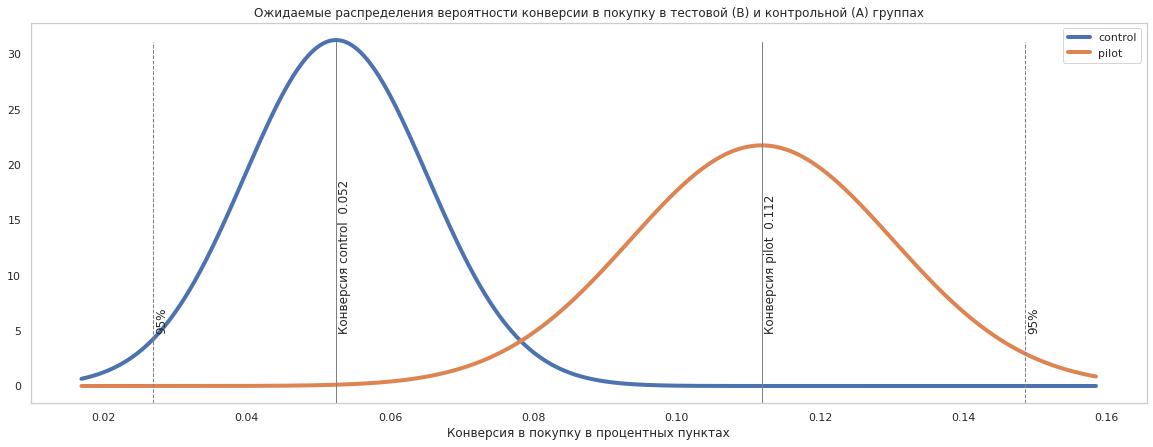

In [28]:
visualisation(common)

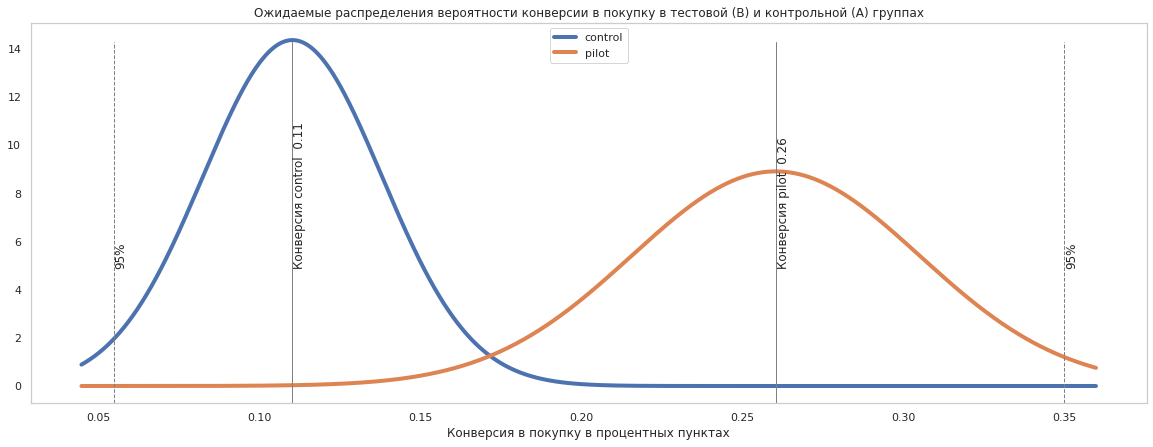

In [29]:
visualisation(active)

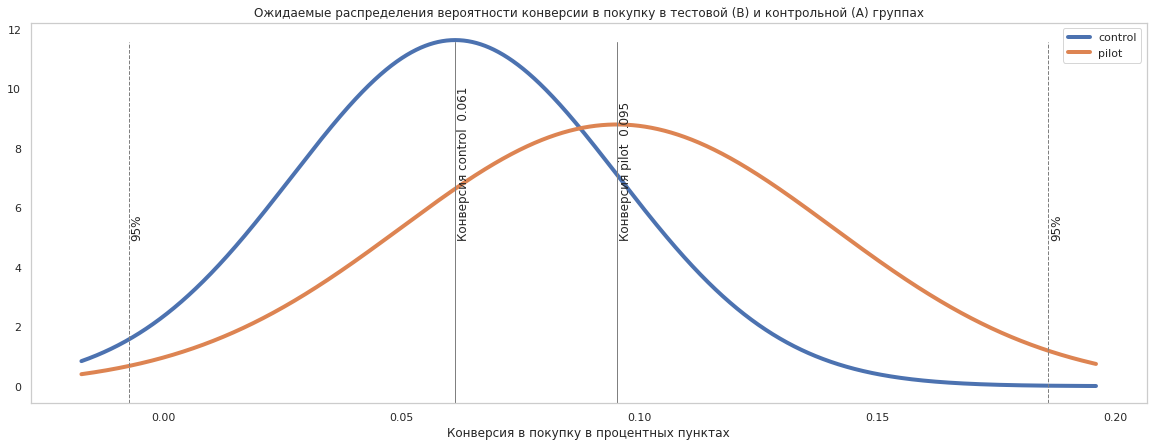

In [30]:
visualisation(math)

**Выводы и рекомендации**

Было проведено А/В-тестирование для проверки следующей нулевой гипотезы: при введении новой механики оплаты услуг конверсия в покупку не изменится. Для оценки статистической значимости результатов использовался критерий Хи-квадрат.

Несмотря на то, что тестирование проводилось всего два дня, был достигнут необходимый объем выборки (165 человек контрольная группа, 143 человека тестовая группа) и в тестовой группе конверсия увеличилась статистически значимо (p-value 0.7%). Следовательно, мы можем принять гипотезу о том, что данное изменение механики оплаты увеличивает конверсию в покупку. Я бы рекомендовала завершить данный тест и внедрить новую механику оплаты.

Рекомендую обратить внимание на предмет математика. Новая система оплаты не повлияла на конверсию в покупку активных пользователей по математике. Могу предположить несколько причин этого:

Математика - очень популярный предмет и имеется много ресурсов, где можно заниматься бесплатно, поэтому конверсия в покупку по математике изначально невысокая.
Небольшой размер выборки создает опасность заблуждений, связанных с законом малых чисел (на маленьких выборках могут получаться экстремальные значения, не отражающие свойства генеральной совокупности).
Курс по математике требует доработки, так как после пробных занятий он не привлекает потребителей. Либо потребителям достаточно бесплатных заданий (они достаточно сложные и интересные), либо потребителям не нравятся бесплатные задания (они недостаточно или чрезмерно сложные).
В любом случае этот вопрос требует дальнейшего рассмотрения и внимания.

В качестве дополнительного исследования рекомендовала бы обратить внимание на то, что среди пользователей, совершивших покупку, есть такие, кто проходил задания по одному предмету, а в итоге приобрел другой. Данная ситуация является необычной и в целях развития бизнеса полезно было бы выяснить причины этой ситуации (через прямые опросы данных пользователей, либо с привлечением других имеющихся данных)